<a href="https://colab.research.google.com/github/caropeboka/shoes-classifier/blob/main/MSIB_Image_Processing_with_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import datasets
import torchvision.models as models
from torch.optim import lr_scheduler

import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pylab as plt
import numpy as np

import os
import glob
from PIL import Image

import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
def train_val_dataset(dataset, val_split=0.25):
  train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
  datasets = {}
  datasets['train'] = Subset(dataset, train_idx)
  datasets['val'] = Subset(dataset, val_idx)
  return datasets

Define paths for the data directory

In [ ]:
TRAIN_PATH = ("drive/MyDrive/Dataset/Shoes/train/")
TEST_PATH = ("drive/MyDrive/Dataset/Shoes/test/")

Transformation for the images

In [ ]:
train_transform = T.Compose([
    T.Resize(224),
    T.ToTensor()
])

Load all data from the data directory

In [ ]:
train_data = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
train_data = train_val_dataset(train_data)
test_data = datasets.ImageFolder(TEST_PATH, transform=T.ToTensor())

Define customized CNN model

Our CNN model contains 2 hidden layers and 1 fully-connected layer.

In [ ]:
# define CNN model
class CNN(nn.Module):
    # constructor
    def __init__(self, out_1=16, out_2=16):
        super(CNN, self).__init__()
        # first hidden layer
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2, stride=1) # output width: 224
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # output width: 112
        # second hidden layer
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2, stride=1) # output width: 112
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # output width: 56
        
        self.fc1 = nn.Linear(out_2 * 56 * 56,128)
        self.fc2 = nn.Linear(128, 3)

        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

Model Configuration (loss function and optimizer)

In [ ]:
model = CNN()
model.to
criterion = nn.CrossEntropyLoss()
lr = 0.01 #learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

#create data loaders
train_loader = DataLoader(train_data['train'], batch_size=10, shuffle=True)
val_loader = DataLoader(train_data['val'], batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Model Training Function

In [ ]:
train_cost_list = []
train_acc_list = []
val_cost_list = []
val_acc_list = []
N_train=len(train_data['train'])
N_val=len(train_data['val'])

#model training function
def train_model(model, n_epochs):
  min_valid_loss = np.inf

  for epoch in tqdm(range(n_epochs)):
    print(f"Training epoch {epoch}...")
    TRAIN_COST = 0
    train_correct = 0
    for x, y in train_loader:
      if torch.cuda.is_available():
        x = x.to('cuda')
        y = y.to('cuda')
      optimizer.zero_grad() #gradient reset
      z = model(x) #run forward function in model
      loss = criterion(z, y)
      loss.backward()
      optimizer.step()
      TRAIN_COST += loss.data #add loss of each BATCH into total loss of the epoch
      _, yhat = torch.max(z.data, 1)
      train_correct += (yhat == y).sum().item()
    train_cost_list.append(TRAIN_COST) #list of total loss of each epoch
    train_acc_list.append(train_correct / N_train)

    VAL_COST = 0
    val_correct = 0
    for x_val, y_val in val_loader:
      if torch.cuda.is_available():
        x_val = x_val.to('cuda')
        y_val = y_val.to('cuda')
      optimizer.zero_grad()
      z = model(x_val)
      loss = criterion(z, y_val)
      VAL_COST += loss.data
      _, yhat = torch.max(z.data, 1)
      val_correct += (yhat == y_val).sum().item()

    val_cost_list.append(VAL_COST)
    val_acc_list.append(val_correct / N_val)

    print(f'Epoch {epoch+1} \t\t Training Loss: {TRAIN_COST / len(train_loader)} \t\t Validation Loss: {VAL_COST / len(val_loader)}')
    if min_valid_loss > VAL_COST:
      print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{VAL_COST:.6f}) \t Saving The Model')
      min_valid_loss = VAL_COST
      #Saving State Dict
      torch.save(model.state_dict(), 'saved_model.pth')

Model Training

In [ ]:
n_epochs = 20
train_model(model, n_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 0...


  5%|▌         | 1/20 [01:32<29:15, 92.41s/it]

Epoch 1 		 Training Loss: 1.14228355884552 		 Validation Loss: 1.0988595485687256
Validation Loss Decreased(inf--->19.779472) 	 Saving The Model
Training epoch 1...


 10%|█         | 2/20 [02:01<16:29, 54.98s/it]

Epoch 2 		 Training Loss: 1.0977202653884888 		 Validation Loss: 1.0994172096252441
Training epoch 2...


 15%|█▌        | 3/20 [02:31<12:23, 43.71s/it]

Epoch 3 		 Training Loss: 1.0968869924545288 		 Validation Loss: 1.1913886070251465
Training epoch 3...


 20%|██        | 4/20 [03:00<10:04, 37.77s/it]

Epoch 4 		 Training Loss: 1.1153324842453003 		 Validation Loss: 1.09379243850708
Validation Loss Decreased(19.779472--->19.688263) 	 Saving The Model
Training epoch 4...


 25%|██▌       | 5/20 [03:28<08:37, 34.50s/it]

Epoch 5 		 Training Loss: 1.09269380569458 		 Validation Loss: 1.0915251970291138
Validation Loss Decreased(19.688263--->19.647453) 	 Saving The Model
Training epoch 5...


 30%|███       | 6/20 [03:57<07:37, 32.66s/it]

Epoch 6 		 Training Loss: 1.0919309854507446 		 Validation Loss: 1.0910661220550537
Validation Loss Decreased(19.647453--->19.639191) 	 Saving The Model
Training epoch 6...


 35%|███▌      | 7/20 [04:26<06:48, 31.42s/it]

Epoch 7 		 Training Loss: 1.0655092000961304 		 Validation Loss: 1.1019147634506226
Training epoch 7...


 40%|████      | 8/20 [04:55<06:05, 30.50s/it]

Epoch 8 		 Training Loss: 1.0349503755569458 		 Validation Loss: 1.0539950132369995
Validation Loss Decreased(19.639191--->18.971910) 	 Saving The Model
Training epoch 8...


 45%|████▌     | 9/20 [05:22<05:23, 29.40s/it]

Epoch 9 		 Training Loss: 1.034970760345459 		 Validation Loss: 1.075542688369751
Training epoch 9...


 50%|█████     | 10/20 [05:49<04:46, 28.61s/it]

Epoch 10 		 Training Loss: 0.9872702956199646 		 Validation Loss: 1.0762490034103394
Training epoch 10...


 55%|█████▌    | 11/20 [06:14<04:09, 27.74s/it]

Epoch 11 		 Training Loss: 0.9984877109527588 		 Validation Loss: 1.069942593574524
Training epoch 11...


 60%|██████    | 12/20 [06:40<03:37, 27.16s/it]

Epoch 12 		 Training Loss: 0.8846133351325989 		 Validation Loss: 1.3238255977630615
Training epoch 12...


 65%|██████▌   | 13/20 [07:06<03:07, 26.77s/it]

Epoch 13 		 Training Loss: 0.8005934953689575 		 Validation Loss: 1.2873369455337524
Training epoch 13...


 70%|███████   | 14/20 [07:33<02:40, 26.81s/it]

Epoch 14 		 Training Loss: 0.6261937022209167 		 Validation Loss: 1.1093528270721436
Training epoch 14...


 75%|███████▌  | 15/20 [07:59<02:12, 26.55s/it]

Epoch 15 		 Training Loss: 0.5996628999710083 		 Validation Loss: 1.2783664464950562
Training epoch 15...


 80%|████████  | 16/20 [08:25<01:45, 26.43s/it]

Epoch 16 		 Training Loss: 0.45178738236427307 		 Validation Loss: 1.329152226448059
Training epoch 16...


 85%|████████▌ | 17/20 [08:51<01:19, 26.38s/it]

Epoch 17 		 Training Loss: 0.3205704092979431 		 Validation Loss: 1.4564967155456543
Training epoch 17...


 90%|█████████ | 18/20 [09:18<00:53, 26.52s/it]

Epoch 18 		 Training Loss: 0.2407388985157013 		 Validation Loss: 1.9508404731750488
Training epoch 18...


 95%|█████████▌| 19/20 [09:45<00:26, 26.58s/it]

Epoch 19 		 Training Loss: 0.17102552950382233 		 Validation Loss: 4.960335731506348
Training epoch 19...


100%|██████████| 20/20 [10:11<00:00, 30.56s/it]

Epoch 20 		 Training Loss: 0.46779921650886536 		 Validation Loss: 1.6155236959457397


Model Accuracy

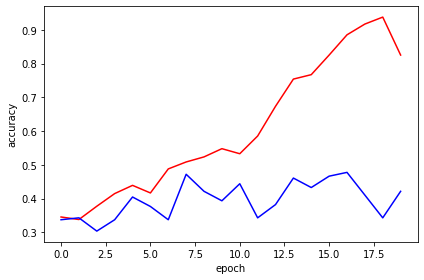

In [ ]:
train_acc_list = torch.tensor(train_acc_list, device = 'cpu')
val_acc_list = torch.tensor(val_acc_list, device = 'cpu')

#Plot

fig, ax1 = plt.subplots()
ax1.plot(train_acc_list, color='red')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.tick_params(axis='y')
ax1.plot(val_acc_list, color='blue')
fig.tight_layout()

Transfer Learning using VGG16

In [ ]:
class MyPretrainModel(nn.Module):
  def __init__(self, my_pretrained_model):
    super(MyPretrainModel, self).__init__()
    self.pretrained = my_pretrained_model
    for param in self.pretrained.parameters():
      param.rewuires_grad = False
    self.my_new_layers = nn.Sequential(nn.Linear(self.pretrained.classifier[-1].out_features, 512),
                                       nn.ReLU(),
                                       nn.Linear(512, 3),)
  def forward(self, x):
    x = self.pretrained(x)
    x = self.my_new_layers(x)
    return x

In [ ]:
model_ft = models.vgg16(pretrained=True)
model_ft = MyPretrainModel(model_ft)
model_ft.to

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

<bound method Module.to of MyPretrainModel(
  (pretrained): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

Reset the last layer of the VGG16 pretrained model

In [ ]:
#initialize loss and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.01 #learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

Train VGG16 Model

In [ ]:
n_epochs = 20

train_cost_list = []
train_acc_list = []
val_cost_list = []
val_acc_list = []
N_train=len(train_data['train'])
N_val=len(train_data['val'])

train_model(model_ft, n_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 0...
Epoch 1 		 Training Loss: 1.1459476947784424 		 Validation Loss: 1.1369706392288208
Validation Loss Decreased(inf--->20.465471) 	 Saving The Model


  5%|▌         | 1/20 [17:09<5:26:03, 1029.68s/it]

Training epoch 1...
Epoch 2 		 Training Loss: 1.1508151292800903 		 Validation Loss: 1.0978931188583374
Validation Loss Decreased(20.465471--->19.762075) 	 Saving The Model


 10%|█         | 2/20 [34:28<5:10:25, 1034.77s/it]

Training epoch 2...


 15%|█▌        | 3/20 [51:35<4:52:11, 1031.24s/it]

Epoch 3 		 Training Loss: 1.1445752382278442 		 Validation Loss: 1.110152006149292
Training epoch 3...


 20%|██        | 4/20 [1:08:41<4:34:31, 1029.45s/it]

Epoch 4 		 Training Loss: 1.1511845588684082 		 Validation Loss: 1.1270866394042969
Training epoch 4...


 25%|██▌       | 5/20 [1:25:48<4:17:04, 1028.32s/it]

Epoch 5 		 Training Loss: 1.139528512954712 		 Validation Loss: 1.129347324371338
Training epoch 5...


 30%|███       | 6/20 [1:42:56<3:59:56, 1028.33s/it]

Epoch 6 		 Training Loss: 1.1487829685211182 		 Validation Loss: 1.1261881589889526
Training epoch 6...


 35%|███▌      | 7/20 [2:00:08<3:43:04, 1029.59s/it]

Epoch 7 		 Training Loss: 1.152633786201477 		 Validation Loss: 1.1148661375045776
Training epoch 7...


 40%|████      | 8/20 [2:17:22<3:26:11, 1030.96s/it]

Epoch 8 		 Training Loss: 1.148587942123413 		 Validation Loss: 1.1290620565414429
Training epoch 8...
Epoch 9 		 Training Loss: 1.1682456731796265 		 Validation Loss: 1.0958491563796997
Validation Loss Decreased(19.762075--->19.725285) 	 Saving The Model


 45%|████▌     | 9/20 [2:34:36<3:09:10, 1031.87s/it]

Training epoch 9...


 50%|█████     | 10/20 [2:51:48<2:51:58, 1031.81s/it]

Epoch 10 		 Training Loss: 1.1488032341003418 		 Validation Loss: 1.107357382774353
Training epoch 10...


 55%|█████▌    | 11/20 [3:08:54<2:34:31, 1030.19s/it]

Epoch 11 		 Training Loss: 1.1452134847640991 		 Validation Loss: 1.1106783151626587
Training epoch 11...


 60%|██████    | 12/20 [3:25:57<2:17:04, 1028.02s/it]

Epoch 12 		 Training Loss: 1.1584490537643433 		 Validation Loss: 1.1093955039978027
Training epoch 12...


 65%|██████▌   | 13/20 [3:42:57<1:59:39, 1025.65s/it]

Epoch 13 		 Training Loss: 1.1611660718917847 		 Validation Loss: 1.1005785465240479
Training epoch 13...


 70%|███████   | 14/20 [3:59:56<1:42:21, 1023.55s/it]

Epoch 14 		 Training Loss: 1.148305058479309 		 Validation Loss: 1.1087912321090698
Training epoch 14...


 75%|███████▌  | 15/20 [4:16:57<1:25:14, 1022.88s/it]

Epoch 15 		 Training Loss: 1.1425806283950806 		 Validation Loss: 1.1390928030014038
Training epoch 15...


 80%|████████  | 16/20 [4:33:57<1:08:07, 1021.98s/it]

Epoch 16 		 Training Loss: 1.152738332748413 		 Validation Loss: 1.1191511154174805
Training epoch 16...


 85%|████████▌ | 17/20 [4:50:58<51:04, 1021.50s/it]  

Epoch 17 		 Training Loss: 1.1408048868179321 		 Validation Loss: 1.1450666189193726
Training epoch 17...


 90%|█████████ | 18/20 [5:08:00<34:03, 1021.74s/it]

Epoch 18 		 Training Loss: 1.145503044128418 		 Validation Loss: 1.1168071031570435
Training epoch 18...


 95%|█████████▌| 19/20 [5:24:58<17:00, 1020.56s/it]

Epoch 19 		 Training Loss: 1.1472681760787964 		 Validation Loss: 1.104392409324646
Training epoch 19...


100%|██████████| 20/20 [5:41:58<00:00, 1025.95s/it]

Epoch 20 		 Training Loss: 1.1561167240142822 		 Validation Loss: 1.1322131156921387


Model Accuracy

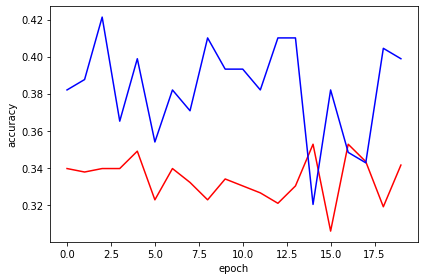

In [ ]:
train_acc_list = torch.tensor(train_acc_list, device = 'cpu')
val_acc_list = torch.tensor(val_acc_list, device = 'cpu')

#Plot the Loss and Accuracy vs Epoch graph

fig, ax1 = plt.subplots()
ax1.plot(train_acc_list, color='red')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.tick_params(axis='y')
ax1.plot(val_acc_list, color='blue')
fig.tight_layout()